# Movie Recommender: PSL 2023 Final Project
12/10/2023
- Michael Conlin
- Thimira Bandera
- Constantin Kappel

In [ ]:
## Introduction
In this final project we are creating a recommender system for movies, using a modified version of the MovieLens dataset. This is provided for us at https://liangfgithub.github.io/MovieData/. We will create two systems, one ranking the top 5 or 10 movies is a genre chosen by the user, and the other recommending movies based using collaborative filtering. We will also create a web app to allow users to interact with our system.

## Team Members

| Team Members     | NetID    | Program |
| ---------------- | -------- | ------- |
| Thimira Bandera  | thimira2 | MCS     |
| Michael Conlin   | mconlin3 | MCS     |
| Constatin Kappel | normank2 | MCS     |


*Contributions of team members:*
All three team members worked on each part of this homework independently first, then we met as a team regularly and shared what we learned and reviewed each others code. However, Constantin focused on the initial code, Michael focused on debugging, testing, and the notebook for generating the final HTML file, and Tim the front-end of the web app. We then constructed our submission together. So each team member contributed to all sections of the assignment effectively equally.


## Load Libraries

In [17]:
import pandas as pd
from pathlib import Path
from typing import List, Dict
from tqdm import tqdm
import seaborn as sns
import numpy as np
import torch
import requests

## Data
Below we create functions to download the data from our provided website, save them to a local directory, and load them into a pandas dataframes.

The data is an excerpt from the Movielens dataset. 

In [36]:
datapath = Path("../data/")

In [33]:
myurl = Path("https:///liangfgithub.github.io/MovieData/")

In [26]:
def download_data(url: str, path: Path):
    try:
        print(f"Downloading data from {url} ...")
        r = requests.get(url, allow_redirects=True)
        with open(path, 'wb') as f:
            f.write(r.content)
    except Exception as e:
        print(e)
        return False

In [6]:
def load_data(path: Path, header: List[str], ignore_index=True) -> pd.DataFrame:
    with open(path, mode='r', encoding='iso8859-1') as f:
        lines = f.readlines()
    df = pd.DataFrame(map(parse_line, lines), columns=header)
    return df

def parse_line(line: str, sep="::", ignore_index=True) -> List[str]:
    row = line.split(sep=sep)
    row = [s.strip() for s in row]
    #row = dict(zip(header, row))
    if ignore_index: pass
        #row = row[1:]
    return row

### Basic Data Exploration

In [37]:
users = load_data(datapath/"users.dat", header=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [38]:
ratings = load_data(datapath/"ratings.dat", header=['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [39]:
movies = load_data(datapath/"movies.dat", header=['MovieID', 'Title', 'Genres', ])
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


### Ratings Matrix
Although we provide the code below to create a ratings matrix, we will not use it in this assignment. Instead, we will use the ratings matrix provided from Coursera to ensure accuracy.

In [381]:
# load the ratings matrix from coursera
rmat = pd.read_csv(datapath/"Rmat.csv", index_col=0)

In [136]:
print(rmat.head())
print("The minimum value for a rating is: ", rmat.min(axis=None))

        m1  m10  m100  m1000  m1002  m1003  m1004  m1005  m1006  m1007  ...  \
u1     5.0  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
u10    5.0  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
u100   NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
u1000  5.0  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
u1001  4.0  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   

       m99  m990  m991  m992  m993  m994  m996  m997  m998  m999  
u1     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u10    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u100   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u1000  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u1001  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 3706 columns]
The minimum value for a rating is:  1.0


### Preprocessing

Convert numbers to integers:

In [42]:
users['UserID'] = users['UserID'].astype(int)
users['Age'] = users['Age'].astype(int)
users['Occupation'] = users['Occupation'].astype(int)

In [43]:
movies['MovieID'] = movies['MovieID'].astype(int)

In [44]:
ratings['UserID'] = ratings['UserID'].astype(int)
ratings['MovieID'] = ratings['MovieID'].astype(int)
ratings['Rating'] = ratings['Rating'].astype(int)

Convert timestamp to datetime:

In [45]:
ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')

/var/folders/1k/_vbt366j733689p_fb6d0lyw0000gn/T/ipykernel_35242/2279367575.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')


Extract movie names for R matrix

In [46]:
# Create dict of movie names and movie ids
movie_dict = dict(zip(movies['MovieID'], movies['Title']))
movie_dict_inv = dict(zip(movies['Title'], movies['MovieID']))

In [382]:
# How many Movies do we have?
len(movie_dict)

3883

Split genres into array

In [48]:
# Split genres (by "|" separator) into np.array
movies['Genres'] = movies['Genres'].apply(lambda x: np.array(x.split('|')))

In [49]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy]
3879,3949,Requiem for a Dream (2000),[Drama]
3880,3950,Tigerland (2000),[Drama]
3881,3951,Two Family House (2000),[Drama]


In [50]:
# testing to see if our np.array is working for searching genres
print(movies.iloc[0]['Genres'])
print("Comedy" in movies.iloc[0]['Genres'])
print("Thriller" in movies.iloc[0]['Genres'])

['Animation' "Children's" 'Comedy']
True
False


These are the movie genres:

In [51]:
all_genres = movies['Genres'].explode().unique()
all_genres

array(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir',
       'Western'], dtype=object)

## Explore data

These are the genders:

In [24]:
users['Gender'].value_counts()

Gender
M    4331
F    1709
Name: count, dtype: int64

Age distribution:

In [25]:
users['Age'].value_counts()

Age
25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: count, dtype: int64

Occupation distribution (not used later):

In [52]:
users['Occupation'].value_counts()

Occupation
4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: count, dtype: int64

Dictionaries for use with other functions:

In [53]:
# dict with age groups:
age_dict = {
    1:  "Under 18",
    18:  "18-24",
    25:  "25-34",
    35:  "35-44",
    45:  "45-49",
    50:  "50-55",
    56:  "56+"
}

# dict with occupations:
occupations_dict = {
    0:  "other",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}

In [54]:
users['Occupation'].apply(lambda x: occupations_dict[x])

0               K-12 student
1              self-employed
2                  scientist
3       executive/managerial
4                     writer
                ...         
6035               scientist
6036       academic/educator
6037       academic/educator
6038                   other
6039      doctor/health care
Name: Occupation, Length: 6040, dtype: object

How many unique movies are there?

In [55]:
movies['MovieID'].nunique()

3883

How many ratings are there?

In [56]:
ratings['MovieID'].nunique()

3706

Not all movies are rated by all users.

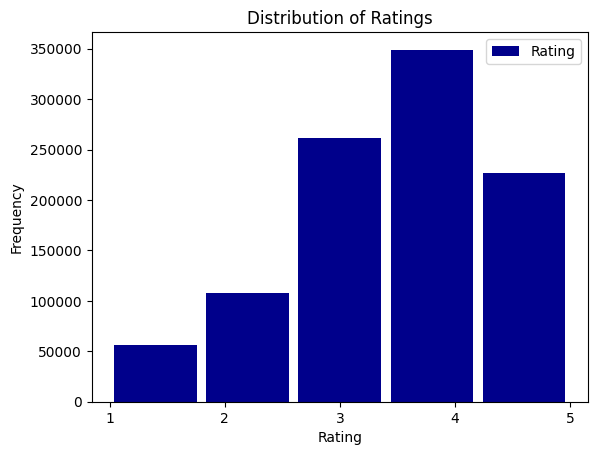

In [57]:
# Distribution of ratings

import matplotlib.pyplot as plt

ratings['Rating'].hist(bins=5, grid=False, align='mid', rwidth=0.9, color='darkblue', label='Rating')
plt.xticks(range(1, 6))  # Set the x-axis ticks to range from 1 to 5
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.legend()
plt.show()


## Build recommender System I

Recommendation based on genres:

We have built a this recommender system based on the genres of the movies, using both "most popular" and "highly rated" as the criteria for recommendation.

- The proposal for "most popular" is to recommend the movies with the highest number of ratings. 
  - specifically we count the number of ratings for each movie, and then sort the movies by the number of ratings in descending order, for each genre.
- The proposal for "highly-rated" is to recommend the movies with the highest rating.
  - specifically we calculate the average rating for each movie, and then sort the movies by the average rating in descending order, for each genre.

<Axes: >

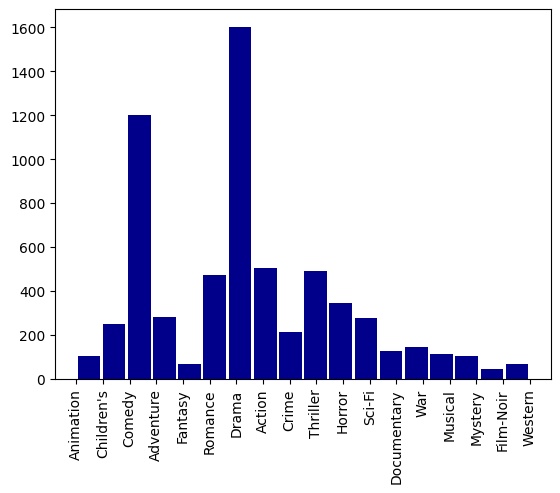

In [58]:
# Distribution of ratings per genre
movies.Genres.explode().hist(xrot=90, bins=len(all_genres), grid=False, align='mid', rwidth=0.9, color='darkblue', label='Rating')

In [383]:
# get MovieIDs of movies with genre
genre = "Animation"
movie_ids = movies[movies['Genres'].apply(lambda x: genre in x)]['MovieID'].unique()

In [387]:
movie_ids[:20]

array([  1,  13,  48, 239, 244, 313, 364, 558, 588, 594, 595, 596, 610,
       616, 631, 661, 673, 709, 720, 741])

In [389]:
movies.loc[movies['MovieID'].isin(movie_ids), 'Title'].unique()[:20]

array(['Toy Story (1995)', 'Balto (1995)', 'Pocahontas (1995)',
       'Goofy Movie, A (1995)', 'Gumby: The Movie (1995)',
       'Swan Princess, The (1994)', 'Lion King, The (1994)',
       'Pagemaster, The (1994)', 'Aladdin (1992)',
       'Snow White and the Seven Dwarfs (1937)',
       'Beauty and the Beast (1991)', 'Pinocchio (1940)',
       'Heavy Metal (1981)', 'Aristocats, The (1970)',
       'All Dogs Go to Heaven 2 (1996)',
       'James and the Giant Peach (1996)', 'Space Jam (1996)',
       'Oliver & Company (1988)',
       'Wallace & Gromit: The Best of Aardman Animation (1996)',
       'Ghost in the Shell (Kokaku kidotai) (1995)'], dtype=object)

<Axes: >

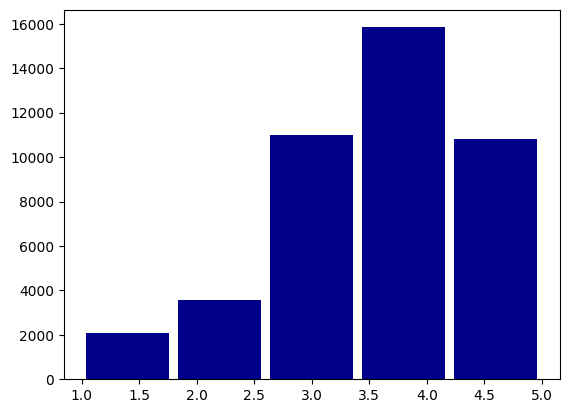

In [62]:
# Get ratings of movies with genre
ratings[ratings['MovieID'].isin(movie_ids)]['Rating'].hist(bins=5, grid=False, align='mid', rwidth=0.9, color='darkblue', label='Rating')

#### Most Popular Function

In [71]:
def get_top_n_most_popular_movies_by_genre(movies: pd.DataFrame, 
                                           ratings: pd.DataFrame, 
                                           genre: str, 
                                           n: int, 
                                           top: bool = True) -> List[str]:
    """AttributeErrorGet top n most popular movies by genre (movies with highest or lowest number of ratings)

    Args:
        movies (pd.DataFrame): Movies dataframe
        ratings (pd.DataFrame): Ratings dataframe
        genre (str): Genre to filter movies by
        n (int): Number of movies to return
        top (bool, optional): Whether to return top or bottom n movies. Defaults to True.

    Returns:
        List[str]: List of movie names
    """
    all_genres = movies['Genres'].explode().unique()
    assert genre in all_genres, f"Genre {genre} not found in list of genres"
    movie_ids = movies[movies['Genres'].apply(lambda x: genre in x)]['MovieID'].unique()
    if top:
        idx = ratings[ratings['MovieID'].isin(movie_ids)].value_counts().head(n).index.get_level_values(1).values
    else:
        idx = ratings[ratings['MovieID'].isin(movie_ids)].value_counts().tail(n).index.get_level_values(1).values
    return list(movies.loc[movies['MovieID'].isin(idx), 'Title'].unique())

In [64]:
get_top_n_most_popular_movies_by_genre(movies, ratings, "Animation", 5, top=True)

['Toy Story (1995)',
 'Sword in the Stone, The (1963)',
 'Dumbo (1941)',
 "Pete's Dragon (1977)",
 'Jungle Book, The (1967)']

In [68]:
get_top_n_most_popular_movies_by_genre(movies, ratings, "Action", 5, top=True)

['Star Wars: Episode IV - A New Hope (1977)',
 'Lethal Weapon (1987)',
 'Lethal Weapon 2 (1989)',
 'Lethal Weapon 3 (1992)',
 'Wild Wild West (1999)']

In [69]:
get_top_n_most_popular_movies_by_genre(movies, ratings, "Action", 5, top=False)

['Mad Max (1979)',
 'Mad Max 2 (a.k.a. The Road Warrior) (1981)',
 'Mad Max Beyond Thunderdome (1985)',
 'Action Jackson (1988)']

### Highly Rated Function

In [72]:
def get_top_n_highly_rated_movies_by_genre(movies: pd.DataFrame, 
                                           ratings: pd.DataFrame, 
                                           genre: str, 
                                           n: int, 
                                           top: bool = True) -> List[str]:
    """Get top n most highly rated movies by genre (movies with highest or lowest average rating)

    Args:
        movies (pd.DataFrame): Movies dataframe
        ratings (pd.DataFrame): Ratings dataframe
        genre (str): Genre to filter movies by
        n (int): Number of movies to return
        top (bool, optional): Whether to return top or bottom n movies. Defaults to True.

    Returns:
        List[str]: List of movie names
    """
    all_genres = movies['Genres'].explode().unique()
    assert genre in all_genres, f"Genre {genre} not found in list of genres"
    movie_ids = movies[movies['Genres'].apply(lambda x: genre in x)]['MovieID'].unique()
    if top:
        idx = ratings[ratings['MovieID'].isin(movie_ids)].groupby(by='MovieID').mean().sort_values(by='Rating', ascending=False).head(n).index.values
    else:
        idx = ratings[ratings['MovieID'].isin(movie_ids)].groupby(by='MovieID').mean().sort_values(by='Rating', ascending=True).head(n).index.values
    print(movies[movies['MovieID'].isin(idx)])
    #print(movies.loc[movies['MovieID'].isin(idx)])
    return list(movies.loc[movies['MovieID'].isin(idx), 'Title'].unique())

In [73]:
# testing ratings code
n = 10
idx = ratings[ratings['MovieID'].isin(movie_ids)].groupby(by='MovieID').mean().sort_values(by='Rating', ascending=False).head(n).index.values
idx
# result = grp.filter(lambda x: (x['MovieID'] == 260).any())
# np.mean(result["Rating"])

array([ 745, 1148,  720, 1223, 3429, 3114, 3000,    1,  741, 2761])

In [74]:
# testing above code
movies[movies['MovieID'].isin(idx)]

,MovieID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
711,720,Wallace & Gromit: The Best of Aardman Animatio...,[Animation]
731,741,Ghost in the Shell (Kokaku kidotai) (1995),"[Animation, Sci-Fi]"
735,745,"Close Shave, A (1995)","[Animation, Comedy, Thriller]"
1132,1148,"Wrong Trousers, The (1993)","[Animation, Comedy]"
1205,1223,"Grand Day Out, A (1992)","[Animation, Comedy]"
2692,2761,"Iron Giant, The (1999)","[Animation, Children's]"
2931,3000,"Princess Mononoke, The (Mononoke Hime) (1997)","[Action, Adventure, Animation]"
3045,3114,Toy Story 2 (1999),"[Animation, Children's, Comedy]"
3360,3429,Creature Comforts (1990),"[Animation, Comedy]"


In [76]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Animation", 5, top=True)

      MovieID                                              Title  \
711       720  Wallace & Gromit: The Best of Aardman Animatio...   
735       745                              Close Shave, A (1995)   
1132     1148                         Wrong Trousers, The (1993)   
1205     1223                            Grand Day Out, A (1992)   
3360     3429                           Creature Comforts (1990)   

                             Genres  
711                     [Animation]  
735   [Animation, Comedy, Thriller]  
1132            [Animation, Comedy]  
1205            [Animation, Comedy]  
3360            [Animation, Comedy]  


['Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Close Shave, A (1995)',
 'Wrong Trousers, The (1993)',
 'Grand Day Out, A (1992)',
 'Creature Comforts (1990)']

In [77]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Animation", 5, top=False)

      MovieID                            Title  \
241       244          Gumby: The Movie (1995)   
626       631   All Dogs Go to Heaven 2 (1996)   
2985     3054  Pokémon: The First Movie (1998)   
3730     3799    Pokémon the Movie 2000 (2000)   
3875     3945        Digimon: The Movie (2000)   

                                  Genres  
241              [Animation, Children's]  
626     [Animation, Children's, Musical]  
2985             [Animation, Children's]  
3730             [Animation, Children's]  
3875  [Adventure, Animation, Children's]  


['Gumby: The Movie (1995)',
 'All Dogs Go to Heaven 2 (1996)',
 'Pokémon: The First Movie (1998)',
 'Pokémon the Movie 2000 (2000)',
 'Digimon: The Movie (2000)']

In [78]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Sci-Fi", 10, top=True)

      MovieID                                              Title  \
257       260          Star Wars: Episode IV - A New Hope (1977)   
537       541                                Blade Runner (1982)   
740       750  Dr. Strangelove or: How I Learned to Stop Worr...   
1178     1196  Star Wars: Episode V - The Empire Strikes Back...   
1181     1199                                      Brazil (1985)   
1182     1200                                      Aliens (1986)   
1196     1214                                       Alien (1979)   
1220     1240                             Terminator, The (1984)   
1233     1253              Day the Earth Stood Still, The (1951)   
2502     2571                                 Matrix, The (1999)   

                                       Genres  
257      [Action, Adventure, Fantasy, Sci-Fi]  
537                       [Film-Noir, Sci-Fi]  
740                             [Sci-Fi, War]  
1178  [Action, Adventure, Drama, Sci-Fi, War]  
1181       

['Star Wars: Episode IV - A New Hope (1977)',
 'Blade Runner (1982)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Brazil (1985)',
 'Aliens (1986)',
 'Alien (1979)',
 'Terminator, The (1984)',
 'Day the Earth Stood Still, The (1951)',
 'Matrix, The (1999)']

In [79]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Sci-Fi", 5, top=False)

      MovieID                               Title                       Genres
1362     1383     Adrenalin: Fear the Rush (1996)             [Action, Sci-Fi]
1671     1720                 Time Tracers (1995)  [Action, Adventure, Sci-Fi]
3504     3573                  Carnosaur 2 (1995)             [Horror, Sci-Fi]
3505     3574  Carnosaur 3: Primal Species (1996)             [Horror, Sci-Fi]
3524     3593            Battlefield Earth (2000)             [Action, Sci-Fi]


['Adrenalin: Fear the Rush (1996)',
 'Time Tracers (1995)',
 'Carnosaur 2 (1995)',
 'Carnosaur 3: Primal Species (1996)',
 'Battlefield Earth (2000)']

In [49]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Thriller", 5, top=False)

      MovieID                                      Title  \
65         66  Lawnmower Man 2: Beyond Cyberspace (1996)   
1149     1165                   Bloody Child, The (1996)   
1406     1430                          Underworld (1997)   
3595     3664  Puppet Master 5: The Final Chapter (1994)   
3597     3666                  Retro Puppetmaster (1999)   

                          Genres  
65            [Sci-Fi, Thriller]  
1149           [Drama, Thriller]  
1406                  [Thriller]  
3595  [Horror, Sci-Fi, Thriller]  
3597  [Horror, Sci-Fi, Thriller]  


['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Bloody Child, The (1996)',
 'Underworld (1997)',
 'Puppet Master 5: The Final Chapter (1994)',
 'Retro Puppetmaster (1999)']

In [50]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Thriller", 5, top=True)

      MovieID                       Title                         Genres
49         50  Usual Suspects, The (1995)              [Crime, Thriller]
735       745       Close Shave, A (1995)  [Animation, Comedy, Thriller]
892       904          Rear Window (1954)            [Mystery, Thriller]
1194     1212       Third Man, The (1949)            [Mystery, Thriller]
2693     2762     Sixth Sense, The (1999)                     [Thriller]


['Usual Suspects, The (1995)',
 'Close Shave, A (1995)',
 'Rear Window (1954)',
 'Third Man, The (1949)',
 'Sixth Sense, The (1999)']

## Build recommender System II

### Recommendation based on item-based collaborative filtering

#### Create our own Ratings Matrix
We ended up not using this, and instead used the ratings matrix provided by Coursera.

In [51]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:16
1,1,661,3,2000-12-31 22:34:40
2,1,914,3,2000-12-31 22:32:32
3,1,3408,4,2000-12-31 22:04:48
4,1,2355,5,2001-01-06 23:38:40
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:44
1000205,6040,1094,5,2000-04-25 23:21:36
1000206,6040,562,5,2000-04-25 23:19:28
1000207,6040,1096,4,2000-04-26 02:20:48


In [80]:
# Create rating matrix users x movies
# NaN values are not rated movies
# rows: users
# columns: movies
# values: ratings
R = ratings.pivot(index='UserID', columns='MovieID', values='Rating')

In [81]:
ratings.pivot(index='UserID', columns='MovieID', values='Rating')

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [390]:
def id2title(movie_id: int, movie_dict: dict) -> str:
    """Get movie title from movie id

    Args:
        movie_id (int): Movie id
        movie_dict (dict): Dictionary with movie ids as keys and movie titles as values

    Returns:
        str: Movie title
    """
    if movie_id in movie_dict.keys():
        title = movie_dict[movie_id]
    else:
        title = f"MovieID_{movie_id}"
    return title

In [391]:
movie_names = R.columns.map(lambda x: id2title(x, movie_dict))
movie_names

Index(['MovieID_Toy Story (1995)', 'MovieID_Jumanji (1995)',
       'MovieID_Grumpier Old Men (1995)', 'MovieID_Waiting to Exhale (1995)',
       'MovieID_Father of the Bride Part II (1995)', 'MovieID_Heat (1995)',
       'MovieID_Sabrina (1995)', 'MovieID_Tom and Huck (1995)',
       'MovieID_Sudden Death (1995)', 'MovieID_GoldenEye (1995)',
       ...
       'MovieID_Bamboozled (2000)', 'MovieID_Bootmen (2000)',
       'MovieID_Digimon: The Movie (2000)', 'MovieID_Get Carter (2000)',
       'MovieID_Get Carter (1971)', 'MovieID_Meet the Parents (2000)',
       'MovieID_Requiem for a Dream (2000)', 'MovieID_Tigerland (2000)',
       'MovieID_Two Family House (2000)', 'MovieID_Contender, The (2000)'],
      dtype='object', name='MovieID', length=3706)

In [392]:
R.columns = movie_names
R

MovieID,MovieID_Toy Story (1995),MovieID_Jumanji (1995),MovieID_Grumpier Old Men (1995),MovieID_Waiting to Exhale (1995),MovieID_Father of the Bride Part II (1995),MovieID_Heat (1995),MovieID_Sabrina (1995),MovieID_Tom and Huck (1995),MovieID_Sudden Death (1995),MovieID_GoldenEye (1995),...,MovieID_Bamboozled (2000),MovieID_Bootmen (2000),MovieID_Digimon: The Movie (2000),MovieID_Get Carter (2000),MovieID_Get Carter (1971),MovieID_Meet the Parents (2000),MovieID_Requiem for a Dream (2000),MovieID_Tigerland (2000),MovieID_Two Family House (2000),"MovieID_Contender, The (2000)"
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [393]:
R.sum(axis=0).sort_values(ascending=False).index[:10]

Index(['MovieID_American Beauty (1999)',
       'MovieID_Star Wars: Episode IV - A New Hope (1977)',
       'MovieID_Star Wars: Episode V - The Empire Strikes Back (1980)',
       'MovieID_Star Wars: Episode VI - Return of the Jedi (1983)',
       'MovieID_Saving Private Ryan (1998)',
       'MovieID_Raiders of the Lost Ark (1981)',
       'MovieID_Silence of the Lambs, The (1991)',
       'MovieID_Matrix, The (1999)', 'MovieID_Sixth Sense, The (1999)',
       'MovieID_Terminator 2: Judgment Day (1991)'],
      dtype='object', name='MovieID')

In [397]:
idx_top_10_popular = R.sum(axis=0).sort_values(ascending=False).index[:10]
print(idx_top_10_popular)
# list(map(lambda x: movie_dict_inv[x], idx_top_10_popular))

Index(['MovieID_American Beauty (1999)',
       'MovieID_Star Wars: Episode IV - A New Hope (1977)',
       'MovieID_Star Wars: Episode V - The Empire Strikes Back (1980)',
       'MovieID_Star Wars: Episode VI - Return of the Jedi (1983)',
       'MovieID_Saving Private Ryan (1998)',
       'MovieID_Raiders of the Lost Ark (1981)',
       'MovieID_Silence of the Lambs, The (1991)',
       'MovieID_Matrix, The (1999)', 'MovieID_Sixth Sense, The (1999)',
       'MovieID_Terminator 2: Judgment Day (1991)'],
      dtype='object', name='MovieID')


In [395]:
tops = R.sum(axis=0)
# extract numerical index from index
tops

MovieID
MovieID_Toy Story (1995)                      8613.0
MovieID_Jumanji (1995)                        2244.0
MovieID_Grumpier Old Men (1995)               1442.0
MovieID_Waiting to Exhale (1995)               464.0
MovieID_Father of the Bride Part II (1995)     890.0
                                               ...  
MovieID_Meet the Parents (2000)               3134.0
MovieID_Requiem for a Dream (2000)            1251.0
MovieID_Tigerland (2000)                       198.0
MovieID_Two Family House (2000)                156.0
MovieID_Contender, The (2000)                 1467.0
Length: 3706, dtype: float64

In [90]:
# Normalize rating matrix R by centering each row around its mean (ignore NaN values)
R_norm = R.sub(R.mean(axis=1, skipna=True), axis=0)

In [91]:
R_norm

MovieID,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Bamboozled (2000),Bootmen (2000),Digimon: The Movie (2000),Get Carter (2000),Get Carter (1971),Meet the Parents (2000),Requiem for a Dream (2000),Tigerland (2000),Two Family House (2000),"Contender, The (2000)"
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.811321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.146465,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,-1.302928,NaN,-0.302928,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate the cosine similarity between each pair of users


$$S_{ij} = \frac{1}{2} + \frac{1}{2}\frac{\sum_{l \in \mathcal{I_{ij}}}{R_{li}R_{lj}}}{\sqrt{\sum_{l \in \mathcal{I_{ij}}}{R_{li}^2}}\sqrt{\sum_{l \in \mathcal{I_{ij}}}{R_{lj}^2}}}$$

$\mathcal{I_{ij}}$ is the movie which users i and j have both rated.

For each row, sort the non-NA similarity measures and keep the top 30, setting the rest to NA. This new similarity matrix, still denoted as S, is no longer symmetric.

## Similarity Matrix Calculation

In [138]:
# explore rmat
print(rmat.head())
print("The shape of rmat is: ", rmat.shape)
print("The minimum value for a rating is: ", rmat.min(axis=None))

        m1  m10  m100  m1000  m1002  m1003  m1004  m1005  m1006  m1007  ...  \
u1     5.0  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
u10    5.0  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
u100   NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
u1000  5.0  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
u1001  4.0  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   

       m99  m990  m991  m992  m993  m994  m996  m997  m998  m999  
u1     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u10    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u100   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u1000  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u1001  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 3706 columns]
The shape of rmat is:  (6040, 3706)
The minimum value for a rating is:  1.0


In [115]:
# Normalize rating matrix R by centering each row around its mean (ignore NaN values)
rmat_norm = rmat.sub(rmat.mean(axis=1, skipna=True), axis=0)
# This was tested and performs as expected

,m1,m10,m100,m1000,m1002,m1003,m1004,m1005,m1006,m1007,...,m99,m990,m991,m992,m993,m994,m996,m997,m998,m999
u1,0.811321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u10,0.885287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1000,0.869048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1001,0.347480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
# Explore rmat_norm
print(rmat_norm.head())
print("The shape of rmat_norm is: ", rmat_norm.shape)
print("The minimum value for a rating is: ", rmat_norm.min(axis=None))
print("The maximum value for a rating is: ", rmat_norm.max(axis=None))

             m1  m10  m100  m1000  m1002  m1003  m1004  m1005  m1006  m1007  \
u1     0.811321  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u10    0.885287  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u100        NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u1000  0.869048  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u1001  0.347480  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

       ...  m99  m990  m991  m992  m993  m994  m996  m997  m998  m999  
u1     ...  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u10    ...  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u100   ...  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u1000  ...  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
u1001  ...  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 3706 columns]
The shape of rmat_norm is:  (6040, 3706)
The minimum value for a rat

#### Similarity Matrix Calculation

In [189]:
rmat_norm_tensor = torch.tensor(np.array(rmat_norm))
num_movies = rmat_norm_tensor.shape[1]
sim_matrix = torch.zeros((num_movies, num_movies))

for i in tqdm(range(num_movies)):
    for j in range(i + 1, num_movies):
        ratings_i = rmat_norm_tensor[:, i]
        ratings_j = rmat_norm_tensor[:, j]
        sim_value = float('nan')
        # index of users that have rated both movies i and j
        shared_users = ~torch.isnan(ratings_i) & ~torch.isnan(ratings_j)
        # only use movies that have been rated by at least 3 users
        if torch.count_nonzero(shared_users).item() > 2:
            shared_reviews_i = ratings_i[shared_users]
            shared_reviews_j = ratings_j[shared_users]
            # compute cosine similarity using the two movies' ratings vectors
            numerator = torch.sum(shared_reviews_i * shared_reviews_j)
            denominator_i = torch.sqrt(torch.sum(shared_reviews_i ** 2))
            denominator_j = torch.sqrt(torch.sum(shared_reviews_j ** 2))
            # only compute similarity if both denominators are not 0, else it will remain nan
            if denominator_i != 0 and denominator_j != 0:
                sim_value = 0.5 + 0.5 * (numerator / (denominator_i * denominator_j))
                sim_value = sim_value.item()
        # set similarity value in both directions
        sim_matrix[i, j] = sim_value
        sim_matrix[j, i] = sim_value

# return sim_matrix
sim_matrix

100%|██████████| 3706/3706 [14:24<00:00,  4.29it/s] 


tensor([[0.0000, 0.5121, 0.3920,  ..., 0.5140, 0.3838, 0.4145],
        [0.5121, 0.0000, 0.5475,  ..., 0.6687, 0.4483, 0.6008],
        [0.3920, 0.5475, 0.0000,  ..., 0.2696, 0.4789, 0.6128],
        ...,
        [0.5140, 0.6687, 0.2696,  ..., 0.0000, 0.6426, 0.4606],
        [0.3838, 0.4483, 0.4789,  ..., 0.6426, 0.0000, 0.6427],
        [0.4145, 0.6008, 0.6128,  ..., 0.4606, 0.6427, 0.0000]])

In [190]:
# save the unfiltered similarity matrix as a pandas dataframe
sim_df = pd.DataFrame(sim_matrix, index=rmat_norm.columns, columns=rmat_norm.columns)
np.fill_diagonal(sim_df.values, np.nan)
sim_df

,m1,m10,m100,m1000,m1002,m1003,m1004,m1005,m1006,m1007,...,m99,m990,m991,m992,m993,m994,m996,m997,m998,m999
m1,NaN,0.512106,0.392000,0.729637,0.405249,0.344362,0.193479,0.292097,0.275762,0.434214,...,0.525635,0.167886,0.438244,0.204408,0.551756,0.683422,0.290653,0.514043,0.383772,0.414505
m10,0.512106,NaN,0.547458,0.490472,NaN,0.610983,0.423742,0.460659,0.657699,0.549540,...,0.261701,0.465863,0.448079,0.385735,NaN,0.454464,0.547504,0.668733,0.448290,0.600812
m100,0.392000,0.547458,NaN,0.482965,NaN,0.836584,0.629538,0.568282,0.811807,0.488524,...,0.410753,0.642616,0.493640,0.193671,0.802844,0.306743,0.629374,0.269576,0.478923,0.612815
m1000,0.729637,0.490472,0.482965,NaN,NaN,0.180765,NaN,NaN,NaN,0.705223,...,NaN,NaN,0.207393,0.901521,NaN,0.226027,0.668436,NaN,0.725336,0.680574
m1002,0.405249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.722766,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m994,0.683422,0.454464,0.306743,0.226027,0.722766,0.251738,0.227186,0.140286,0.249062,0.274397,...,0.401180,0.148686,0.470518,0.192859,0.539714,NaN,0.215561,0.449014,0.307824,0.398517
m996,0.290653,0.547504,0.629374,0.668436,NaN,0.790889,0.711965,0.691134,0.806075,0.621695,...,0.618137,0.779649,0.478071,0.797518,NaN,0.215561,NaN,0.077113,0.556378,0.622558
m997,0.514043,0.668733,0.269576,NaN,NaN,0.366023,0.932724,0.949228,0.214426,0.210009,...,0.215711,0.866121,0.416222,NaN,0.412018,0.449014,0.077113,NaN,0.642635,0.460646
m998,0.383772,0.448290,0.478923,0.725336,NaN,0.445008,0.843772,0.604815,0.354571,0.504146,...,NaN,0.698391,0.662904,0.852328,NaN,0.307824,0.556378,0.642635,NaN,0.642727


In [192]:
# save sim_df as a csv
sim_df.to_csv(datapath/"sim_df.csv")

#### Similarity Matrix Results
Here we compare our results with those shared by other users on Campuswire for the following movies: m1, m10, m100, m1510, m260, m3212 and our results are identical to those posted online.

In [193]:
sim_df.loc[["m1", "m10", "m100", "m1510", "m260", "m3212"], ["m1", "m10", "m100", "m1510", "m260", "m3212"]]


,m1,m10,m100,m1510,m260,m3212
m1,NaN,0.512106,0.392000,NaN,0.741148,NaN
m10,0.512106,NaN,0.547458,NaN,0.534334,NaN
m100,0.392000,0.547458,NaN,NaN,0.329694,NaN
m1510,NaN,NaN,NaN,NaN,NaN,NaN
m260,0.741148,0.534334,0.329694,NaN,NaN,NaN
m3212,NaN,NaN,NaN,NaN,NaN,NaN


#### Top 30 Similarity Matrix Calculation

In [194]:
num_movies = sim_matrix.shape[1]
sim_matrix_np = np.array(sim_matrix)
sim_matrix_top = np.zeros((num_movies, num_movies))
# Set all NaN values to 0 to prevent them from being in the top 30
sim_matrix_np[np.isnan(sim_matrix_np)] = 0

# Keep only top 30
for i in tqdm(range(num_movies)):
        row = sim_matrix_np[i, :]
        top_indices = np.argpartition(row, -30, axis=0)[-30:]
        sim_matrix_top[i, top_indices] = row[top_indices]

sim_matrix_top[sim_matrix_top == 0] = float('nan')

100%|██████████| 3706/3706 [00:00<00:00, 22907.94it/s]


#### Test the Similarity Matrix Masking Operation

In [195]:
sim_matrix_top

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [196]:
sim_top_df = pd.DataFrame(sim_matrix_top, index=rmat_norm.columns, columns=rmat_norm.columns)
sim_top_df

,m1,m10,m100,m1000,m1002,m1003,m1004,m1005,m1006,m1007,...,m99,m990,m991,m992,m993,m994,m996,m997,m998,m999
m1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
# save sim_top_df as a csv
sim_top_df.to_csv(datapath/"sim_top_df.csv")

In [198]:
sim_df.loc['m260', 'm10']

0.53433377

## Create a function named myIBCF:
Input: newuser, a `n_movies-by-1` vector (denoted as w) containing ratings for the `n_movies` movies from a new user. Many entries in this vector will be zero. The order of the movies in this vector should match the rating matrix R. (Should we center w? For IBCF, centering the new user ratings is not necessary.)

Inside the function: 
- Upon receiving this input, your function should download the similarity matrix
- use it to compute predictions for movies that have not been rated by this new user yet. 
- Use the following formula to compute the prediction p for movie l
$$p(l) = \frac{1}{\sum_{i \in S(l)}S_{li}}\sum_{i \in S_(l)}S_{li}w_i$$

where S(l) denotes the set of movies in the 30-nearest neighborhood of movie l.

Again NA values may occur.

Output: Based on your predictions, recommend the top 10 movies to this new user, using the column names of the rating matrix R

Explain what your code should do if fewer than 10 predictions are non-NA. Provide a method to suggest additional movies that have not been rated by this user.

In [354]:
# determine the top ten most popular movies
top_ten = rmat.sum(axis=0).sort_values(ascending=False).index[:10]
top_ten

Index(['m2858', 'm260', 'm1196', 'm1210', 'm2028', 'm1198', 'm593', 'm2571',
       'm2762', 'm589'],
      dtype='object')

In [360]:
def myIBCF(w: np.array, R: pd.DataFrame, S: np.array, k=30) -> Dict[int, str]:
    """_summary_

    Args:
        w (np.array): new user vector of ratings, n_movies x 1
        R (pd.DataFrame): rating matrix with movie names for columns, n_users x n_movies
        S (np.array): similarity matrix, n_movies x n_movies
        k (int, optional): number of neighbors. Defaults to 30.

    Returns:
        List[str]: top 10 movie recommendations as list of names
    """
    # get the index of movies has the user not rated?
    notrated = np.where(np.isnan(w))[0]
    rated = np.where(~np.isnan(w))[0]
    

    # vectors to store the movies and ratings
    movies_temp = []
    ratings_temp = []

    # loop through the unrated movies
    for l in notrated:
        # l is the index of the movie in rmat and should match the index in S
        if np.nansum((S[l, rated])) > 0:
            left = 1/(np.nansum((S[l, rated])))
            top_indices = np.where(~np.isnan(S[l, :]))[0]
            right = np.nansum(S[l, top_indices] * w[top_indices])
            # get the movie 'name'
            movies_temp.append(R.columns[l])
            # calculate the rating
            ratings_temp.append(left * right)

    # save as a dataframe so we can sort easily
    rec_df = pd.DataFrame({"Movie": movies_temp, "Rating": ratings_temp})
    # sort by rating
    rec_df = rec_df.sort_values(by="Rating", ascending=False)
    # convert to a dictionary
    rec_dict = dict(zip(rec_df["Movie"], rec_df["Rating"]))
    # if there are less than 10 movies, add the top 10 most popular movies
    if len(rec_dict) < 10:
        top_ten = R.sum(axis=0).sort_values(ascending=False).index[:10]
        for i in top_ten:
            if i not in rec_dict.keys():
                rec_dict[i] = 0
    # return the top 10 movies  
    rec_dict = dict(list(rec_dict.items())[:10])
    return rec_dict

### Top 10 Ratings for User 1181

In [369]:
w1181 = np.array(rmat.loc['u1181', :])
# type(w1181)
recs = myIBCF(w1181, rmat, sim_matrix_top, k=30)
print("\n".join("{}\t{}".format(k, v) for k, v in recs.items()))


m3732	5.0
m749	4.526559173684237
m3899	4.526066007170667
m2793	4.0
m249	4.0
m2082	4.0
m1914	4.0
m504	4.0
m1039	4.0
m427	4.0


### Top 10 Ratings for User 1351

In [370]:
w1351 = np.array(rmat.loc['u1351', :])
# type(w1351)
recs = myIBCF(w1351, rmat, sim_matrix_top, k=30)
print("\n".join("{}\t{}".format(k, v) for k, v in recs.items()))

m985	5.0
m1514	5.0
m1659	5.0
m3380	5.0
m3373	5.0
m3232	5.0
m1780	5.0
m318	5.0
m1871	5.0
m1877	5.0


### Top 10 Ratings for Hypothetical User

In [379]:
rmat_copy = rmat.iloc[0, :].copy()
rmat_copy[:] = np.nan
type(rmat_copy)
w_hypo = rmat_copy
w_hypo.loc['m1613'] = 5
w_hypo.loc['m1755'] = 4
recs = myIBCF(w_hypo, rmat, sim_matrix_top, k=30)
print("\n".join("{}\t{}".format(k, v) for k, v in recs.items()))


/var/folders/1k/_vbt366j733689p_fb6d0lyw0000gn/T/ipykernel_35242/2733199581.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  right = np.nansum(S[l, top_indices] * w[top_indices])


m2688	5.000000000000001
m2548	5.000000000000001
m3466	5.000000000000001
m1707	5.000000000000001
m46	5.000000000000001
m3254	5.0
m361	5.0
m3566	5.0
m3536	5.0
m340	5.0
